## Background and data
The US has some of the [highest per capita healthcare costs in the world](https://www.commonwealthfund.org/publications/fund-reports/2021/aug/mirror-mirror-2021-reflecting-poorly). As a non-American, the healthcare system and its costs really interest me; this [data made available by Miri Choi](https://www.kaggle.com/datasets/mirichoi0218/insurance) got me thinking "is it possible to predict healthcare costs based on some basic biometric and family info?"

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/insurance/insurance.csv


## Previewing data
First, let's explore the dataset.

In [3]:
data = pd.read_csv("/kaggle/input/insurance/insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Some first thoughts: 
- Features are fairly limited and it seems difficult to engineer new features using this raw data. For example, BMI [isn't actually a good indicator of health](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2930234/). A healthy powerlifter might have a BMI that is in the "obese" range.
- The `children` column might be unnecessary based on common sense, but might be colinear with another feature (e.g. `region`). There are healthy and unhealthy parents who have lots of children, and the same goes for individuals with little/ no children.

Despite these limitations, let's explore some more anyways.

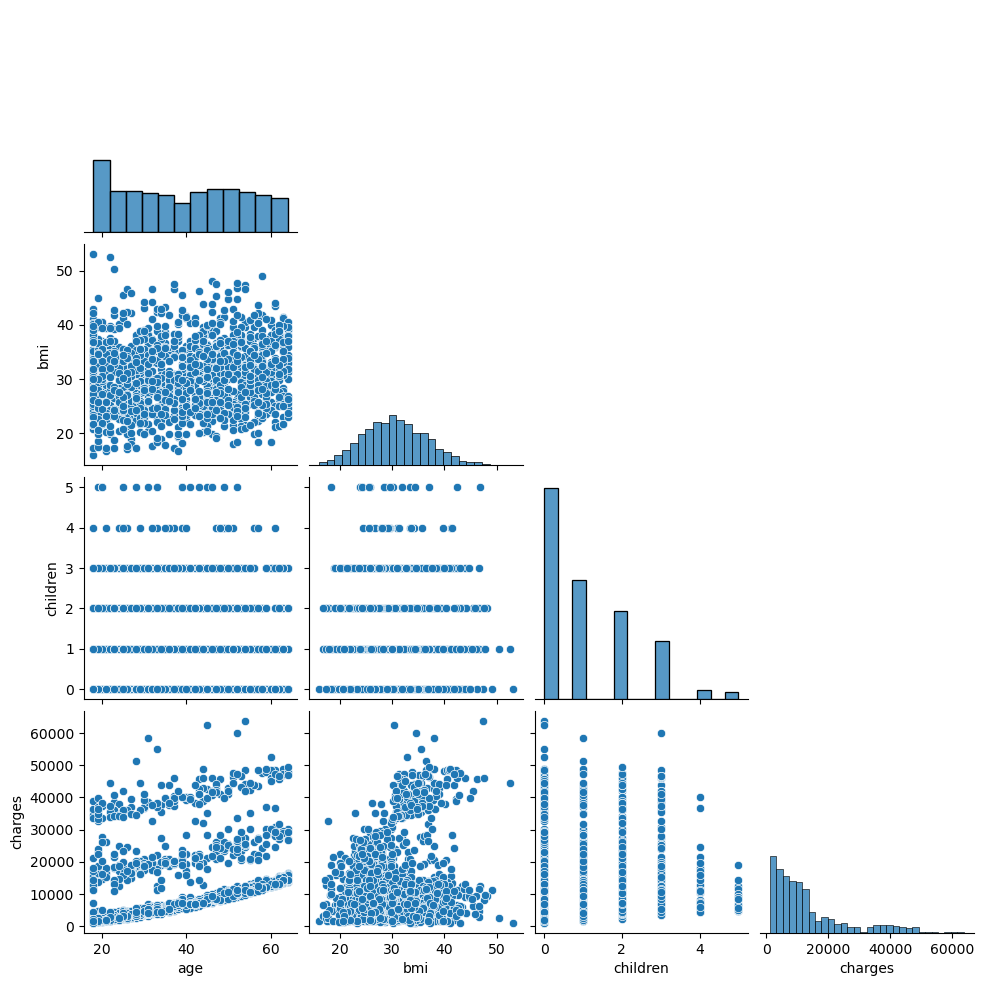

In [5]:
sns.pairplot(data, corner=True)

## Observations about the data 
* The target variable `charges` isn't normally distributed; it might not be easy predicting it. We might have better luck predicting its log function.

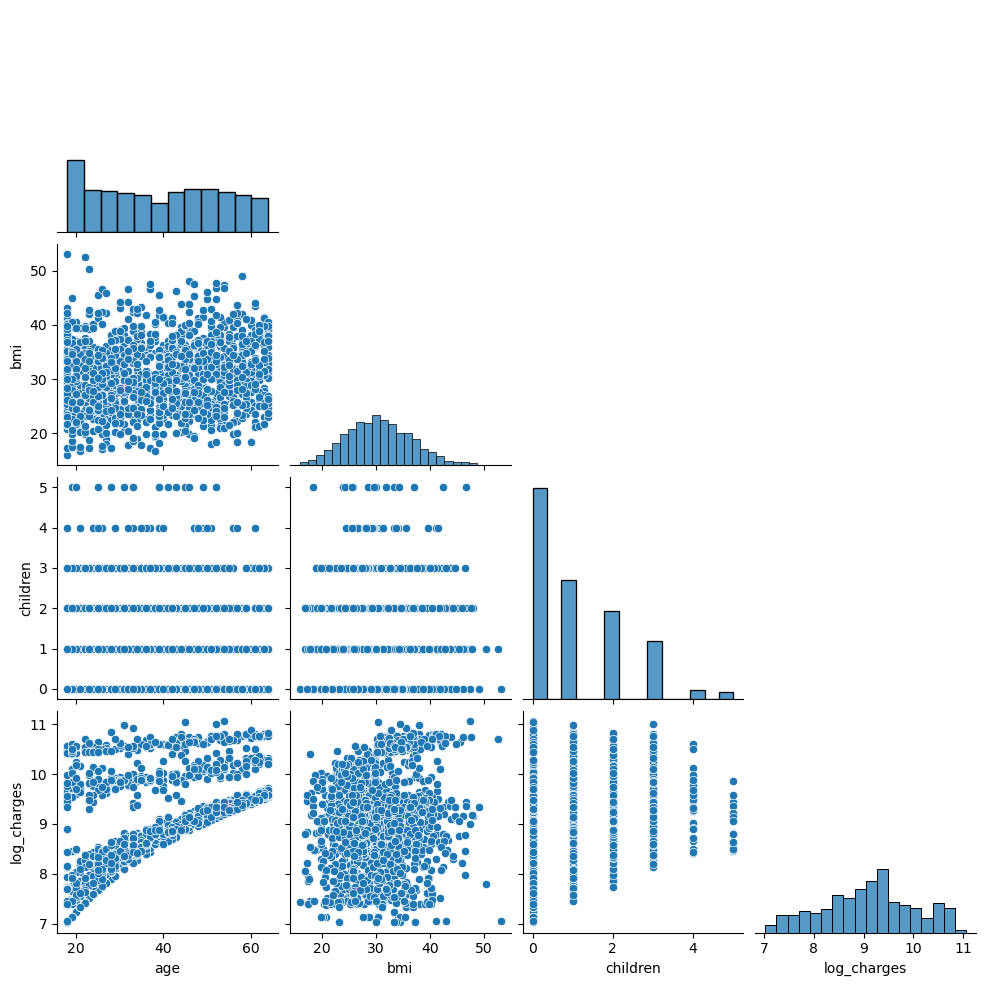

In [6]:
data['log_charges'] = np.log(data['charges'])
sns.pairplot(data.loc[:, data.columns != 'charges']
             , corner=True)

The distribution of `log_charges` is much more normalized now!

* As I predicted, `children` doesn't look like a good indicator of the target variable (e.g. those with 0 children has as wide of a spread as those with 3 kids), BUT the individual costs are much lower when the subscriber has 4+ kids.
* The "charges by age" plot is interesting; every age has high and low ranges of healthcare costs, but there isn't much cardinality within the ages. For example, for a 60 year old, it looks like healthcare costs are 10k annually, or 25k, or 45k. There aren't many 60 year olds with costs between 30-40k.

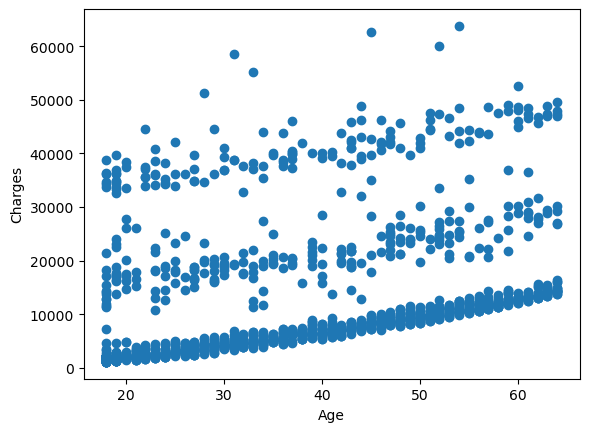

In [7]:
plt.scatter(data['age'], data['charges'])
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

## Data cleaning / feature engineering
The main work here is converting categorical variables to numerical ones

In [8]:
data['is_smoker'] = [1 if x =='yes' else 0 for x in data['smoker']]
data['is_male'] = [1 if x =='male' else 0 for x in data['sex']]
data.head()

,age,sex,bmi,children,smoker,region,charges,log_charges,is_smoker,is_male
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176,1,0
1,18,male,33.770,1,no,southeast,1725.55230,7.453302,0,1
2,28,male,33.000,3,no,southeast,4449.46200,8.400538,0,1
3,33,male,22.705,0,no,northwest,21984.47061,9.998092,0,1
4,32,male,28.880,0,no,northwest,3866.85520,8.260197,0,1


In [9]:
one_hot = pd.get_dummies(data['region'], drop_first=True)

In [10]:
data = data.join(one_hot)
data.head()

,age,sex,bmi,children,smoker,region,charges,log_charges,is_smoker,is_male,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176,1,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,7.453302,0,1,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,8.400538,0,1,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,9.998092,0,1,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,8.260197,0,1,1,0,0


In [11]:
data.drop(columns=['sex', 'smoker', 'region'], axis=1, inplace=True)
data.head()

,age,bmi,children,charges,log_charges,is_smoker,is_male,northwest,southeast,southwest
0,19,27.900,0,16884.92400,9.734176,1,0,0,0,1
1,18,33.770,1,1725.55230,7.453302,0,1,0,1,0
2,28,33.000,3,4449.46200,8.400538,0,1,0,1,0
3,33,22.705,0,21984.47061,9.998092,0,1,1,0,0
4,32,28.880,0,3866.85520,8.260197,0,1,1,0,0


## Preparing the model

In [12]:
X=data.drop(['log_charges'], axis=1)
y=data.log_charges
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

In [13]:
my_model = XGBRegressor(n_estimators=1000, learning_rate = 0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [14]:
# make predictions
predictions = my_model.predict(test_X)

## Results

In [15]:
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 0.00594313995652685


In [16]:
# `predictions` array is currently log base 10, need to convert back
predictions = pd.DataFrame(np.e ** predictions, columns=['charges'])

In [17]:
predictions.head()

,charges
0,23157.351562
1,3576.006104
2,43762.835938
3,1631.454956
4,11563.078125
